In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
import matplotlib
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from collections import defaultdict

% matplotlib inline

In [2]:
# Create a Dataframe and drop extra column
df = pd.read_csv('./data/features_seattle_911_no_dup.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.Datetime = pd.to_datetime(df.Datetime)

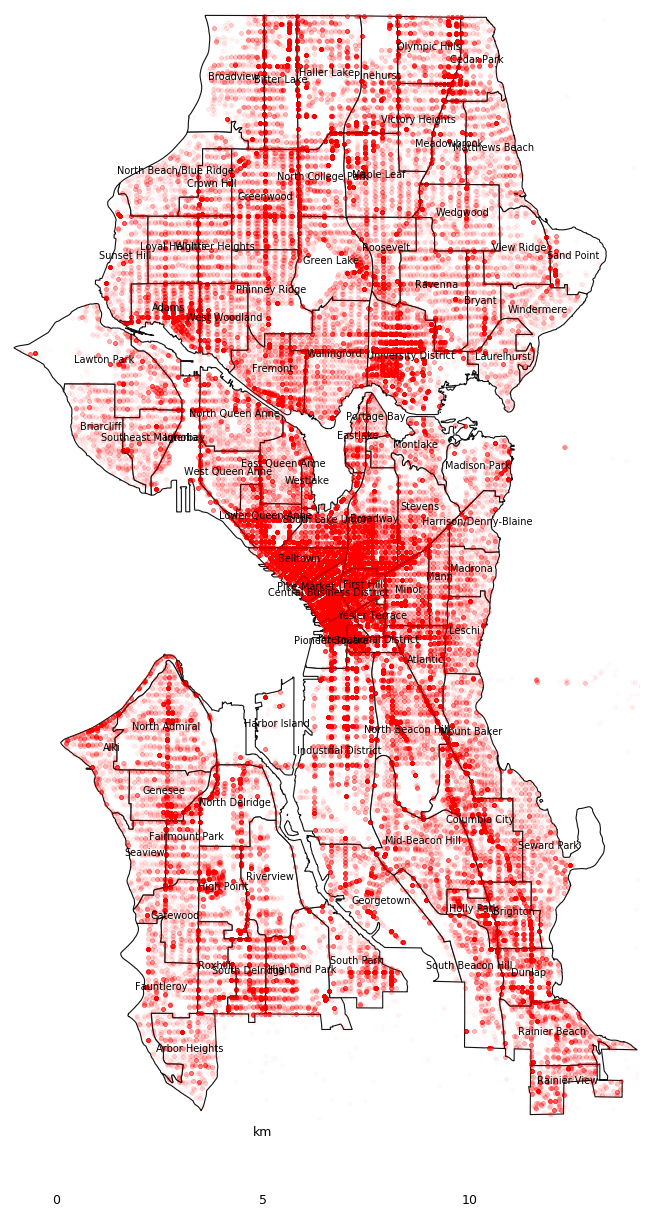

In [3]:
def plot_prepper(m, shapefilename, df_key):
    '''
    Generate dataframe for plotting
    '''
    _out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)
    # set up a map dataframe for neighborhood outlines
    cent_lons = [float((Polygon(points).centroid.wkt).split()[1][1:]) for points in m.seattle]
    cent_lats = [float((Polygon(points).centroid.wkt).strip(')').split()[2]) for points in m.seattle]

    df_poly = pd.DataFrame({
        'poly': [Polygon(points) for points in m.seattle],
        'name': [item[df_key] for item in m.seattle_info],
    })
    df_poly['centroid_1'] = cent_lons
    df_poly['centroid_2'] = cent_lats
    return _out, df_poly

# Read in neighborhood shape file
hood_shapefilename = './neighborhoods_shape/WGS84/Neighborhoods'
hood_coords = (-122.43595589761988, 47.49551362397606, 
               -122.23604445458412, 47.73416494684497)

w, h = hood_coords[2] - hood_coords[0], hood_coords[3] - hood_coords[1]
extra = 0.005

# Initialize the plot
figwidth = 12
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(projection='tmerc', ellps='WGS84',
            lon_0=np.mean([hood_coords[0], hood_coords[2]]),
            lat_0=np.mean([hood_coords[1], hood_coords[3]]),
            llcrnrlon=hood_coords[0] - extra * w,
            llcrnrlat=hood_coords[1] - (extra * h),
            urcrnrlon=hood_coords[2] + extra * w,
            urcrnrlat=hood_coords[3] + (extra * h),
            resolution='i',  suppress_ticks=True)

# Get dataframe for plotting
_out, df_map = plot_prepper(m, hood_shapefilename, 'S_HOOD')
nbr_names = df_map['name'].unique()

# Draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
pc.set_facecolor('w')
ax.add_collection(pc)

# Scale the map
m.drawmapscale(hood_coords[0] + 0.08, hood_coords[1] + -0.01, 
               hood_coords[0], hood_coords[1], 10., barstyle='fancy',
               fillcolor1='w', fillcolor2='#555555', zorder=5, ax=ax,)

lons = df.Longitude
lats = df.Latitude

pt = []
xs = []
ys = []

'''
This plots all the latitude/longitude points
'''
for mapped_x, mapped_y in zip(lons, lats):
    xpt, ypt = m(mapped_x, mapped_y)
    plt.plot(xpt, ypt, '.', s=10 alpha=0.05, color='r')
    pt.append(Point(xpt, ypt))
    xs.append(xpt)
    ys.append(ypt)

Labels = []
nmlist = []

'''
THIS IS THE PART THAT CHECKS WHICH NEIGHBORHOOD A POINT IS IN
'''
# for polygon in df_map['poly']:
#     nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
#     if len(nm.strip()) < 4 or nm in nmlist:
#         continue
#     nmlist.append(nm)
#     for i, p in enumerate(pt):
#         Labels.append('Unknown')
#         if polygon.contains(p):
#             Labels[i] = nm

# Add neighborhood names
nml = []
for i, lon in enumerate(df_map['centroid_1'].values):
    if df_map['name'].values[i] in nml:
        continue
    nml.append(df_map['name'].values[i])
    if len(df_map['name'].values[i]) > 3:
        plt.text(lon, df_map['centroid_2'].values[i], df_map['name'].values[i], size=7, ha='center')

ax.axes.get_xaxis().set_visible(False)
plt.savefig('./images/seattle_911_neighborhoods.png')


In [4]:
if 'Unknown' in Labels:
    print 'yes'
if 'Unknown' not in Labels:
    print 'no'

yes


In [5]:
len(Labels)

551095

In [6]:
len(df)

551095

In [7]:
len(nmlist)

90

In [8]:
len(df_map)

121

In [ ]:
df['neighborhood'] = Labels

In [ ]:
df.to_csv("./data/features_seattle_911_no_dup_hoods.csv")

In [13]:
df.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number,dt_crop,date,time,...,dang_holiday,weekday,night,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,neighborhood
0,6900 37th Av S,Medic Response,2011-11-09 23:33:00,47.540683,-122.286131,"(47.540683, -122.286131)",F110104166,11/09/2011 11:33:00 PM,2011-11-09,23:33:00,...,0,Wednesday,1,0,0,0,0,0,1,Unknown
1,N 50th St / Stone Way N,Aid Response,2011-11-09 23:32:00,47.665034,-122.340207,"(47.665034, -122.340207)",F110104164,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,0,Wednesday,1,0,0,0,0,0,1,Unknown
2,E John St / E Olive Way,Aid Response,2011-11-09 23:32:00,47.619575,-122.324257,"(47.619575, -122.324257)",F110104165,11/09/2011 11:32:00 PM,2011-11-09,23:32:00,...,0,Wednesday,1,0,0,0,0,0,1,Unknown
3,611 12th Av S,Aid Response,2011-11-09 23:29:00,47.597406,-122.317228,"(47.597406, -122.317228)",F110104162,11/09/2011 11:29:00 PM,2011-11-09,23:29:00,...,0,Wednesday,1,0,0,0,0,0,1,Unknown
4,4545 42nd Av Sw,Automatic Medical Alarm,2011-11-09 23:25:00,47.562472,-122.385455,"(47.562472, -122.385455)",F110104161,11/09/2011 11:25:00 PM,2011-11-09,23:25:00,...,0,Wednesday,1,0,0,0,0,0,1,Unknown


In [ ]:
Labels = []
nmlist = []

'''
THIS IS THE PART THAT CHECKS WHICH NEIGHBORHOOD A POINT IS IN
'''
for polygon in df_map['poly']:
    nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
    if len(nm.strip()) < 4 or nm in nm
        continue
    nmlist.append(nm)




In [ ]:
Labels = []
for i, p in enumerate(pt):
    Labels.append('Unknown')
    for j, row in df_map.iterrows():
        polygon = row['poly']
        nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
        if polygon.contains(p):
            Labels[i] = nm

In [ ]:
len(Labels)

In [ ]:
Labels